# Inidivudal ML Transfer Learning Assignment

**Name**: Clara Killeen

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from glob import glob
import cv2
from sklearn.model_selection import train_test_split

In [2]:
print(os.listdir('../Data/archive'))

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv']


### The following is from the kaggle script accompanying this dataset

In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [7]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [13]:
nRowsRead = 1000 # specify 'None' if want to read whole file
df1 = pd.read_csv('../Data/archive/Train.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Train.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 8 columns


In [14]:
df1.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [3]:
train_dir = '../Data/archive/Train'

imageid_path_dict1 = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(train_dir,"*", '*.png'))}

#os.path.join(train_dir,"*", '*.png')

'../Data/archive/Train\\*\\*.png'

In [5]:
list_keys = [ k for k in imageid_path_dict1 ]

In [6]:
imageid_path_dict2 = {imageid_path_dict1[k]: k for k in list_keys}
imageid_path_dict = {imageid_path_dict2[k]:k for k in imageid_path_dict2}

In [16]:
class_dict = {}
for x in imageid_path_dict:
    f_1 = os.path.split(imageid_path_dict[x])
    f_2 = os.path.split(f_1[0])
    class_dict[imageid_path_dict[x]] = f_2[1]

In [27]:
def breakdown(lablist, classes2): #lablist is the labels as a list, classes2 is the final number 
    
    total = 0
    for typ in classes2:
       
        total += lablist.count(typ)


    for typ in classes2:
        print( typ ,":", lablist.count(typ), round(lablist.count(typ)/total, 3))
    print(total)   
    
def labels_quick_order(image_dir, class_dict, classes_final):
    c2 = classes_final
    op = []
    for x in sorted(image_dir):
        op.append(class_dict[image_dir[x]])
        
    labels = np.asarray(op)
    labelslist = (labels.tolist())
    
    labels_num = []
    for x in labelslist:
        for i in range(len(c2)):
            if x == c2[i]:
                labels_num.append(np.asarray([i]))
                
            
    
    labels_num = np.asarray(labels_num)
    print(labels_num.shape)
    return labels_num, labelslist

In [37]:
classes = list(range(43))
classes = [str(x) for x in classes]

In [38]:
labels_num, labels_list =labels_quick_order(imageid_path_dict , class_dict, classes)

(39209, 1)


In [39]:
breakdown(labels_list, classes)

0 : 210 0.005
1 : 2220 0.057
2 : 2250 0.057
3 : 1410 0.036
4 : 1980 0.05
5 : 1860 0.047
6 : 420 0.011
7 : 1440 0.037
8 : 1410 0.036
9 : 1470 0.037
10 : 2010 0.051
11 : 1320 0.034
12 : 2100 0.054
13 : 2160 0.055
14 : 780 0.02
15 : 630 0.016
16 : 420 0.011
17 : 1110 0.028
18 : 1200 0.031
19 : 210 0.005
20 : 360 0.009
21 : 330 0.008
22 : 390 0.01
23 : 510 0.013
24 : 270 0.007
25 : 1500 0.038
26 : 600 0.015
27 : 240 0.006
28 : 540 0.014
29 : 270 0.007
30 : 450 0.011
31 : 780 0.02
32 : 240 0.006
33 : 689 0.018
34 : 420 0.011
35 : 1200 0.031
36 : 390 0.01
37 : 210 0.005
38 : 2070 0.053
39 : 300 0.008
40 : 360 0.009
41 : 240 0.006
42 : 240 0.006
39209


In [71]:
subset = {}
for x in sorted(imageid_path_dict):
    subset[x] = imageid_path_dict[x]
    
    
n = labels_num.shape[0]
list_id = []
for x in sorted(subset):
    list_id.append(x)

    
x_train = np.array(list_id)
y_train = np.array(labels_num)

In [74]:
data_a = []
for x in range(len(subset)):
    nimgb = []
    oimg = cv2.imread(subset[x_train[x]])[...,::-1]
    nimg = cv2.resize(oimg,(150,150))
    nimgb.append(nimg)
    
    data_a.append(nimgb)
data = np.asarray(data_a)

'0'

In [77]:
classes[1]
labels_num

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [42],
       [42],
       [42]])

In [81]:
range(len(subset))
labels_num[1][0]

0

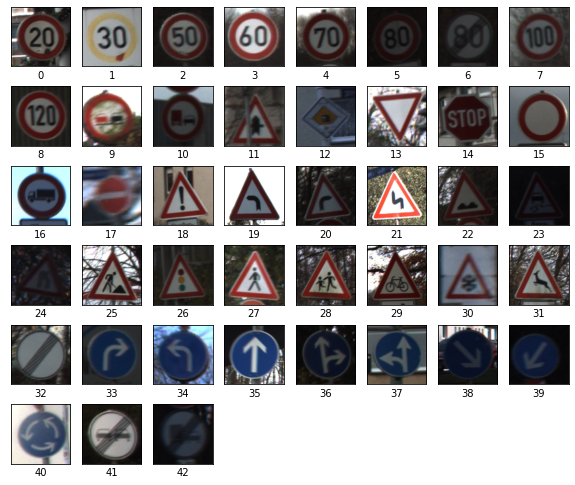

In [85]:
plt.figure(figsize=(10,10))
for i in range(43):
    
    for x in range(len(subset)):
        if labels_num[x][0] == i:
            select = x
    
    plt.subplot(7,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[select,0], cmap=plt.cm.binary)
    plt.xlabel(labels_list[select])

In [68]:
x_train, x_val, y_train, y_val = train_test_split(data, labels_list, test_size = 0.2, random_state = 50)